## Antiguo proyecto de Redes Neuronales Recurrentes usando audios .wav, obteniendo su MFCC, aplicandolos a una RNN y validandolo con k fold cross validation

#### Librerias

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import os
import soundfile as sf
import json
import random
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
random.seed(0)

In [73]:
data = np.array([[1,2,4],[6,7,5],[4,2,9],[0,1,2]])
print(data)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
print(scaled)

[[1 2 4]
 [6 7 5]
 [4 2 9]
 [0 1 2]]
[[0.16666667 0.16666667 0.28571429]
 [1.         1.         0.42857143]
 [0.66666667 0.16666667 1.        ]
 [0.         0.         0.        ]]


#### Funciones a usar

In [85]:
#Obtiene el path con el nombre de todos los archivos de un directorio.
def get_files_from_path(directory):
    path_files = []
    dir_list = os.listdir(directory)
    for path in dir_list:
        path_files.append(directory+"\\"+path)
    return path_files


#Extrae los paths que cumplan con un codigo
def extract_paths_for_emotions_keys(emotions_code, files_path, get_code):
    paths = []
    emotions_set = set(emotions_code)
    for code_file in files_path:
        if (get_code(code_file) in emotions_set):
            paths.append(code_file)
    return paths


#Obtiene el codigo en el nombre del archivo para el dataset CREMA-D
def get_code_esp(path):
    return path[114]#path[110] prueba

def scaled_datas(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

#Esta función abre el archivo .wav y obtiene el mfcc escalado en un vector de 40 elementos.
def features_extractor(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
        mfccs_scaled_features = np.mean(scaled_datas(mfccs_features.T), axis=0)
        return mfccs_scaled_features
    except:
        print("rrrr-", file_name)


#Esta función permite guardar los MFCC en 'features', el código en 'code' y su dirección en 'path' en un archivo json. 
def save_elements_in_json(examples_saved, name):
    json_files = []
    json_file = {}
    index = 0
    for file in examples_saved:
        json_file = {"id": index, "features":[str(elem) for elem in file[0]] ,"code":file[1], "path":file[2]}
        json_files.append(json_file)
        index += 1
    json_object = json.dumps(json_files)
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)
   

#La función permite cargar datos del MFCC y código desde un archivo json.
def load_elements_from_json(name):
    f = open(f'{name}.json')
    data = json.load(f)
    examples = []
    for element in data:
        examples.append(([float(feature) for feature in (element["features"])], element["code"]))
    return examples


#La función nos permite devolver una lista de MFCC obtenidos de una lista de paths. 
#El MFCC tiene un límite que no le permite cargar archivos menor o igual a 44 kb.
#Con el diccionario obtenemos el total de audios recuperados por emoción.
def get_features(paths,get_code, files_filters = dict()):
    examples = []
    for path in paths:
        code = get_code(path)
        file_stats = os.stat(path)
        feature = features_extractor(path)
        files_filters[code]+= 1
        examples.append((feature,code))
    print(f"Se obtuvo el MFCC de unos {len(paths)} sobre {sum(files_filters[files] for files in files_filters)} audios.")
    return examples


#Selecciona n ejemplos que necesitemos y los mezcla.
def select_elements(examples, code, quantity, new_code):
    random.shuffle(examples)
    elements = []
    counter = 1
    for example in examples:
        if (counter > quantity):
            break
        if code == example[1]:
            elements.append((example[0],new_code))
            counter = counter + 1
    return elements

Los siguientes bloques obtienen los paths y filtra las emociones que necesitemos en cada dataset (CREMA-D y SAVEE).

#### Funciones para obtener los datos 

In [86]:
#Obtiene todos los datos de CREMA-D y SAVEE para un  
def get_datas():
    files_path = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\data")
    emotions_code = ["t", "f"]
    datas_files = extract_paths_for_emotions_keys(emotions_code, files_path, get_code_esp)
    examples = []
    files_filters = dict()
    files_filters["t"] = 0
    files_filters["f"] = 0
    examples = get_features(datas_files, get_code_esp, files_filters)
    return examples

#Obtiene los datos de entrada para la red neuronal x: mfcc normalizados, y: labeles categorizados
def get_entries():
    all_examples = get_datas()
    entries = []
    for example in all_examples:
        entries.append((example[0], example[1]))
    datas = select_elements(entries, 't', 400,"without_stress")
    datas += select_elements(entries, 'f', 400, "stress")
    print(datas)
    random.shuffle(datas)
    X = []
    y = []
    for data in datas:
        X.append(data[0])
        y.append(data[1])
    labelencoder=preprocessing.LabelEncoder()
    y = to_categorical(labelencoder.fit_transform(y))
    return X, y

#Obtiene los datos divididos de entrenamiento y tests
def obtain_datas_train_and_test(percentage):
    X, y = get_entries()
    
    X_test, X_train, y_test, y_train = train_test_split(X, y, test_size =percentage,random_state=0)
    y = np.array(y)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [95]:
X_train, X_test, y_train, y_test = obtain_datas_train_and_test(0.8)
num_labels = y_train.shape[1] + y_test.shape[1]
dim_entrada = (X_train.shape[1],1)

Se obtuvo el MFCC de unos 800 sobre 800 audios.
[(array([0.5673535 , 0.55829453, 0.5114996 , 0.48468867, 0.53749907,
       0.5093057 , 0.45147336, 0.50957876, 0.4779198 , 0.5431263 ,
       0.4770046 , 0.46717614, 0.53184813, 0.5592001 , 0.43259603,
       0.56058186, 0.44236028, 0.40844822, 0.29168412, 0.38633856,
       0.42695636, 0.38740626, 0.27523914, 0.29045093, 0.40384337,
       0.30856222, 0.35881492, 0.4874512 , 0.36674917, 0.39834327,
       0.3676682 , 0.36146754, 0.43952647, 0.37284365, 0.5541671 ,
       0.43662193, 0.46917626, 0.48217383, 0.53758514, 0.62154734],
      dtype=float32), 'without_stress'), (array([0.5851439 , 0.60736144, 0.46226555, 0.4900457 , 0.53542906,
       0.45604002, 0.55216855, 0.5000998 , 0.5242895 , 0.4453374 ,
       0.47316945, 0.6161151 , 0.43505523, 0.47889864, 0.4803767 ,
       0.5455522 , 0.5986478 , 0.49390647, 0.47516364, 0.43366548,
       0.45236206, 0.48129633, 0.52932215, 0.56172055, 0.5004589 ,
       0.48486406, 0.5203225 , 0.449

In [46]:
X_train[0]

array([-3.36684204e+02,  1.18518906e+02,  1.07875271e+01,  3.92856102e+01,
        3.43865633e+00, -3.03204584e+00, -1.03807554e+01,  1.22896519e+01,
       -1.35144067e+00,  2.76533842e+00,  7.36702394e+00,  7.99211168e+00,
       -6.99106503e+00,  1.40637720e+00, -4.22262383e+00,  8.65389061e+00,
       -6.15832901e+00, -3.80044192e-01, -1.79595876e+00,  8.10012150e+00,
       -5.25413179e+00, -3.79550648e+00, -3.61556530e+00,  7.07620239e+00,
       -7.50233507e+00,  1.09424853e+00,  9.87752151e+00,  4.52395248e+00,
        7.61083126e+00,  1.54380026e+01,  9.20571327e+00,  5.97800684e+00,
        1.00121603e+01,  3.99951792e+00, -2.68338442e-01,  3.52867556e+00,
       -1.13575131e-01, -4.05465662e-01,  2.06740952e+00, -2.84171438e+00],
      dtype=float32)

In [93]:
'''
def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
#    model.add(LSTM(units=16,input_shape= dim_entrada, return_sequences=True))
#    model.add(LSTM(units=4,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
    
    def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50, input_shape = dim_entrada))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
    
    tang_hiperbolica
'''
#redes neuronales recurrentes
#Datos son audios convertidos a MFCC 
#mayor accuracy o (porcentaje de aciertos) 


#probando nueva arquitectura
def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Activation('relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

    return model


In [94]:
model = new_RNN()
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 50)                10400     
                                                                 
 activation_52 (Activation)  (None, 50)                0         
                                                                 
 activation_53 (Activation)  (None, 50)                0         
                                                                 
 activation_54 (Activation)  (None, 50)                0         
                                                                 
 dropout_44 (Dropout)        (None, 50)                0         
                                                                 
 dense_26 (Dense)            (None, 2)                 102       
                                                                 
Total params: 10,502
Trainable params: 10,502
Non-tra

In [12]:
k_fold = KFold(5)
fold = 0
y_tests = []
predictions = []
scores = []
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
for train, test in k_fold.split(X):
    fold = fold + 1
    print(f"Fold #{fold}")
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    print(f"Train - X:{X_train.shape} y:{y_train.shape}")
    print(f"Test - X:{X_test.shape} y:{y_test.shape}")
    
    num_labels = y.shape[1]
    dim_entrada = (X_train.shape[1],1)

    #model = new_RNN()
    model = new_RNN()
    callbacks = []
    '''
    callbacks = [
    EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=20,
            verbose=1,
        )
    ]
    '''
    num_epochs = 90
    num_batch_size = 20
    start = datetime.datetime.now()
   
    results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)

    pred = model.predict(X_test)
    y_tests.append(y_test)
    pred=[([1,0] if i[0]>i[1] else [0,1]) for i in pred]
    predictions.append(pred)
    score = metrics.accuracy_score(pred, y_test)
    math = confusion_matrix([(1 if x[0]==1 else 0) for x in pred],[(1 if x[0]==1 else 0) for x in y_test], labels=[1,0])
    scores.append([score])
    print(f"Fold score (Accuracy score): {score}")
    print("Matriz de confusion")
    print("-------------------")
    print("---------| Verdadero | Falso |")
    print(f"Verdadero|  {math[0][0]}        {math[0][1]}")
    print(f"Falso    |  {math[1][0]}        {math[1][1]}")

y_tests = np.concatenate(y_tests)
predictions = np.concatenate(predictions)
score = metrics.accuracy_score(predictions, y_tests)
print("-----------------------")
print(f"Cross-validated score (Accuracy score): {score}")
print("-----------------------")
print("Resumen")
for result in scores:
    print(f"Fold score (Accuracy score): {result[0]}")
    
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb
#https://www.youtube.com/watch?v=maiQf8ray_s

NameError: name 'fhmf' is not defined

In [99]:
#50 0.77
model = new_RNN()
model.summary()
#https://keras.io/api/callbacks/early_stopping/
callbacks = []
'''
callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01, #si un epochs mejora como un min_delta respecto a la anterior, no contara como mejora
        patience=70,#numero de epochs sin mejoras que se tendra paciencia
        verbose=1,#mostrar informacion extra, 0 no mostrar
     )
]
'''
num_epochs = 400
num_batch_size = 40
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 50)                10400     
                                                                 
 activation_58 (Activation)  (None, 50)                0         
                                                                 
 activation_59 (Activation)  (None, 50)                0         
                                                                 
 activation_60 (Activation)  (None, 50)                0         
                                                                 
 dropout_46 (Dropout)        (None, 50)                0         
                                                                 
 dense_28 (Dense)            (None, 2)                 102       
                                                                 
Total params: 10,502
Trainable params: 10,502
Non-tra

Epoch 50/400
16/16 [==============================] - 1s 49ms/step - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 51/400
16/16 [==============================] - 1s 51ms/step - loss: 0.6933 - accuracy: 0.4844 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 52/400
16/16 [==============================] - 1s 50ms/step - loss: 0.6934 - accuracy: 0.4734 - val_loss: 0.6931 - val_accuracy: 0.5063
Epoch 53/400
16/16 [==============================] - 1s 46ms/step - loss: 0.6934 - accuracy: 0.4766 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 54/400
16/16 [==============================] - 1s 51ms/step - loss: 0.6929 - accuracy: 0.5063 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 55/400
16/16 [==============================] - 1s 49ms/step - loss: 0.6937 - accuracy: 0.4688 - val_loss: 0.6931 - val_accuracy: 0.5250
Epoch 56/400
16/16 [==============================] - 1s 51ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5312

16/16 [==============================] - 1s 48ms/step - loss: 0.6935 - accuracy: 0.4766 - val_loss: 0.6933 - val_accuracy: 0.4437
Epoch 108/400
16/16 [==============================] - 1s 50ms/step - loss: 0.6932 - accuracy: 0.4875 - val_loss: 0.6933 - val_accuracy: 0.5312
Epoch 109/400
16/16 [==============================] - 1s 52ms/step - loss: 0.6939 - accuracy: 0.4734 - val_loss: 0.6934 - val_accuracy: 0.5188
Epoch 110/400
16/16 [==============================] - 1s 48ms/step - loss: 0.6933 - accuracy: 0.4984 - val_loss: 0.6934 - val_accuracy: 0.5312
Epoch 111/400
16/16 [==============================] - 1s 50ms/step - loss: 0.6938 - accuracy: 0.4953 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 112/400
16/16 [==============================] - 1s 34ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5312
Epoch 113/400
16/16 [==============================] - 1s 32ms/step - loss: 0.6940 - accuracy: 0.4719 - val_loss: 0.6933 - val_accuracy: 0.5250
Epoch 

Epoch 164/400
16/16 [==============================] - 1s 46ms/step - loss: 0.6921 - accuracy: 0.5094 - val_loss: 0.6917 - val_accuracy: 0.5188
Epoch 165/400
16/16 [==============================] - 1s 47ms/step - loss: 0.6918 - accuracy: 0.5328 - val_loss: 0.6923 - val_accuracy: 0.5562
Epoch 166/400
16/16 [==============================] - 1s 49ms/step - loss: 0.6932 - accuracy: 0.5047 - val_loss: 0.6927 - val_accuracy: 0.5125
Epoch 167/400
16/16 [==============================] - 1s 47ms/step - loss: 0.6921 - accuracy: 0.5156 - val_loss: 0.6912 - val_accuracy: 0.5625
Epoch 168/400
16/16 [==============================] - 1s 50ms/step - loss: 0.6932 - accuracy: 0.5094 - val_loss: 0.6914 - val_accuracy: 0.5625
Epoch 169/400
16/16 [==============================] - 1s 48ms/step - loss: 0.6930 - accuracy: 0.5172 - val_loss: 0.6915 - val_accuracy: 0.5312
Epoch 170/400
16/16 [==============================] - 1s 46ms/step - loss: 0.6921 - accuracy: 0.5188 - val_loss: 0.6920 - val_accuracy:

Epoch 221/400
16/16 [==============================] - 1s 47ms/step - loss: 0.6894 - accuracy: 0.5281 - val_loss: 0.6904 - val_accuracy: 0.5375
Epoch 222/400
16/16 [==============================] - 1s 47ms/step - loss: 0.6924 - accuracy: 0.5219 - val_loss: 0.6887 - val_accuracy: 0.5500
Epoch 223/400
16/16 [==============================] - 1s 50ms/step - loss: 0.6918 - accuracy: 0.5094 - val_loss: 0.6888 - val_accuracy: 0.5500
Epoch 224/400
16/16 [==============================] - 1s 46ms/step - loss: 0.6920 - accuracy: 0.5359 - val_loss: 0.6887 - val_accuracy: 0.5625
Epoch 225/400
16/16 [==============================] - 1s 47ms/step - loss: 0.6899 - accuracy: 0.5234 - val_loss: 0.6882 - val_accuracy: 0.5938
Epoch 226/400
16/16 [==============================] - 1s 49ms/step - loss: 0.6932 - accuracy: 0.5109 - val_loss: 0.6908 - val_accuracy: 0.5750
Epoch 227/400
16/16 [==============================] - 1s 48ms/step - loss: 0.6911 - accuracy: 0.5172 - val_loss: 0.6912 - val_accuracy:

Epoch 278/400
16/16 [==============================] - 1s 51ms/step - loss: 0.6908 - accuracy: 0.5266 - val_loss: 0.6855 - val_accuracy: 0.5562
Epoch 279/400
16/16 [==============================] - 1s 48ms/step - loss: 0.6888 - accuracy: 0.5312 - val_loss: 0.6883 - val_accuracy: 0.5688
Epoch 280/400
16/16 [==============================] - 1s 51ms/step - loss: 0.6905 - accuracy: 0.5422 - val_loss: 0.6886 - val_accuracy: 0.5125
Epoch 281/400
16/16 [==============================] - 1s 47ms/step - loss: 0.6873 - accuracy: 0.5359 - val_loss: 0.6867 - val_accuracy: 0.5437
Epoch 282/400
16/16 [==============================] - 1s 43ms/step - loss: 0.6878 - accuracy: 0.5437 - val_loss: 0.6864 - val_accuracy: 0.5625
Epoch 283/400
16/16 [==============================] - 1s 49ms/step - loss: 0.6885 - accuracy: 0.5359 - val_loss: 0.6868 - val_accuracy: 0.5500
Epoch 284/400
16/16 [==============================] - 1s 47ms/step - loss: 0.6890 - accuracy: 0.5219 - val_loss: 0.6851 - val_accuracy:

Epoch 335/400
16/16 [==============================] - 1s 46ms/step - loss: 0.6887 - accuracy: 0.5359 - val_loss: 0.6860 - val_accuracy: 0.5938
Epoch 336/400
16/16 [==============================] - 1s 49ms/step - loss: 0.6872 - accuracy: 0.5437 - val_loss: 0.6845 - val_accuracy: 0.5938
Epoch 337/400
16/16 [==============================] - 1s 48ms/step - loss: 0.6889 - accuracy: 0.5266 - val_loss: 0.6879 - val_accuracy: 0.5562
Epoch 338/400
16/16 [==============================] - 1s 48ms/step - loss: 0.6885 - accuracy: 0.5312 - val_loss: 0.6848 - val_accuracy: 0.5938
Epoch 339/400
16/16 [==============================] - 1s 50ms/step - loss: 0.6880 - accuracy: 0.5375 - val_loss: 0.6861 - val_accuracy: 0.6000
Epoch 340/400
16/16 [==============================] - 1s 45ms/step - loss: 0.6902 - accuracy: 0.5172 - val_loss: 0.6884 - val_accuracy: 0.5625
Epoch 341/400
16/16 [==============================] - 1s 50ms/step - loss: 0.6882 - accuracy: 0.5453 - val_loss: 0.6874 - val_accuracy:

Epoch 392/400
16/16 [==============================] - 1s 47ms/step - loss: 0.6860 - accuracy: 0.5625 - val_loss: 0.6873 - val_accuracy: 0.5750
Epoch 393/400
16/16 [==============================] - 1s 48ms/step - loss: 0.6883 - accuracy: 0.5484 - val_loss: 0.6863 - val_accuracy: 0.5688
Epoch 394/400
16/16 [==============================] - 1s 49ms/step - loss: 0.6827 - accuracy: 0.5359 - val_loss: 0.6873 - val_accuracy: 0.5813
Epoch 395/400
16/16 [==============================] - 1s 46ms/step - loss: 0.6857 - accuracy: 0.5578 - val_loss: 0.6892 - val_accuracy: 0.5938
Epoch 396/400
16/16 [==============================] - 1s 48ms/step - loss: 0.6829 - accuracy: 0.5828 - val_loss: 0.6898 - val_accuracy: 0.5125
Epoch 397/400
16/16 [==============================] - 1s 50ms/step - loss: 0.6882 - accuracy: 0.5281 - val_loss: 0.6879 - val_accuracy: 0.5938
Epoch 398/400
16/16 [==============================] - 1s 47ms/step - loss: 0.6889 - accuracy: 0.5297 - val_loss: 0.6882 - val_accuracy:

In [40]:
def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
#    model.add(LSTM(units=16,input_shape= dim_entrada, return_sequences=True))
#    model.add(LSTM(units=4,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.8200663349917081
-----------------------
Resumen
Fold score (Accuracy score): 0.8281573498964804
Fold score (Accuracy score): 0.8Detector de la mentira usando redes neuronales recurrentes426501035196687
Fold score (Accuracy score): 0.8008298755186722
Fold score (Accuracy score): 0.8174273858921162
Fold score (Accuracy score): 0.8112033195020747
'''

'\nCross-validated score (Accuracy score): 0.8200663349917081\n-----------------------\nResumen\nFold score (Accuracy score): 0.8281573498964804\nFold score (Accuracy score): 0.8Detector de la mentira usando redes neuronales recurrentes426501035196687\nFold score (Accuracy score): 0.8008298755186722\nFold score (Accuracy score): 0.8174273858921162\nFold score (Accuracy score): 0.8112033195020747\n'

In [97]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

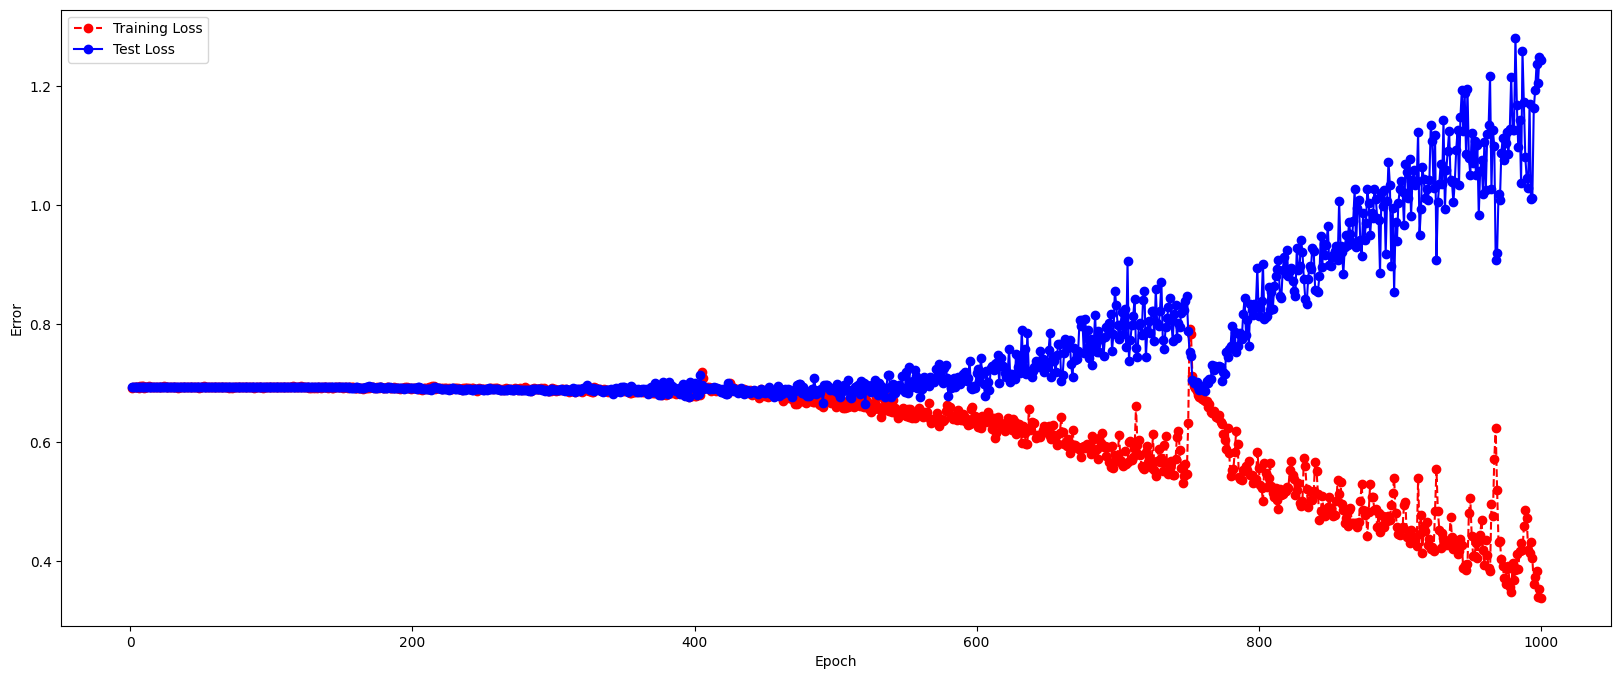

In [98]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [14]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")

y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
    
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

val_loss: 0.40328726172447205 val_accuracy: 0.8150064945220947


NameError: name 'y_values' is not defined

In [77]:
'''
val_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128
val_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128
val_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808
'''

'\nval_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128\nval_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128\nval_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808\n'

#### Crossvalidation

In [57]:
X = np.array(X)
y = np.array(y)
print(f"X:{X.shape} y:{y.shape}")

X:(2236, 40) y:(2236, 2)


In [69]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


El bloque realizara el k fold cross validation dividiendolo en 5 folds, se uso los MSE.

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("model_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_5.h5")
print("Saved model to disk")

Saved model to disk
